# 案例1：咖啡冷却温度预测 - 牛顿冷却定律的非线性回归实现

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [28]:
# 设置中文字体和样式
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 比 SimHei 稳
plt.rcParams['axes.unicode_minus'] = False


In [4]:
print("=" * 60)
print("案例1：咖啡冷却温度预测")
print("基于牛顿冷却定律的非线性回归分析")
print("=" * 60)

案例1：咖啡冷却温度预测
基于牛顿冷却定律的非线性回归分析


# 1. 数据生成与探索

In [5]:

def generate_coffee_data(n_points=20, noise_level=1.0):
    """生成咖啡冷却实验数据"""
    np.random.seed(42)
    
    # 实际测量的时间点（分钟）
    time_data = np.linspace(0, 60, n_points)
    
    # 真实的冷却规律：T = T_room + (T_initial - T_room) * exp(-k*t)
    # 参数设定：室温22°C，初始温度95°C，冷却系数0.045
    T_room = 22  # 室温
    T_initial = 95  # 初始温度
    k = 0.045  # 冷却系数
    
    # 理论温度
    true_temp = T_room + (T_initial - T_room) * np.exp(-k * time_data)
    
    # 添加测量误差（模拟实际测量的不确定性）
    noise = np.random.normal(0, noise_level, len(time_data))
    measured_temp = true_temp + noise
    
    return time_data, measured_temp, true_temp, (T_room, T_initial, k)

# 生成数据
time_data, measured_temp, true_temp, true_params = generate_coffee_data(n_points=25, noise_level=1.2)

# 创建数据框
df = pd.DataFrame({
    '时间(分钟)': time_data,
    '测量温度(°C)': measured_temp,
    '真实温度(°C)': true_temp,
    '温度差': measured_temp - true_temp
})
df.head()

,时间(分钟),测量温度(°C),真实温度(°C),温度差
0,0.0,95.596057,95.000000,0.596057
1,2.5,87.066689,87.232606,-0.165917
2,5.0,81.068910,80.291684,0.777226
3,7.5,75.916930,74.089294,1.827636
4,10.0,68.265871,68.546855,-0.280984


In [6]:
print("\n📊 咖啡冷却实验数据预览：")
print(df.head(10))

print(f"\n📈 数据统计信息：")
print(f"测量时间范围: {time_data.min():.1f} - {time_data.max():.1f} 分钟")
print(f"温度范围: {measured_temp.min():.1f} - {measured_temp.max():.1f} °C")
print(f"平均测量误差: {np.mean(np.abs(df['温度差'])):.2f} °C")


📊 咖啡冷却实验数据预览：
   时间(分钟)   测量温度(°C)   真实温度(°C)       温度差
0     0.0  95.596057  95.000000  0.596057
1     2.5  87.066689  87.232606 -0.165917
2     5.0  81.068910  80.291684  0.777226
3     7.5  75.916930  74.089294  1.827636
4    10.0  68.265871  68.546855 -0.280984
5    12.5  63.313182  63.594146 -0.280964
6    15.0  61.063474  59.168419  1.895055
7    17.5  56.134522  55.213600  0.920922
8    20.0  51.116216  51.679585 -0.563369
9    22.5  49.172671  48.521599  0.651072

📈 数据统计信息：
测量时间范围: 0.0 - 60.0 分钟
温度范围: 25.8 - 95.6 °C
平均测量误差: 0.93 °C


# 2. 数据可视化

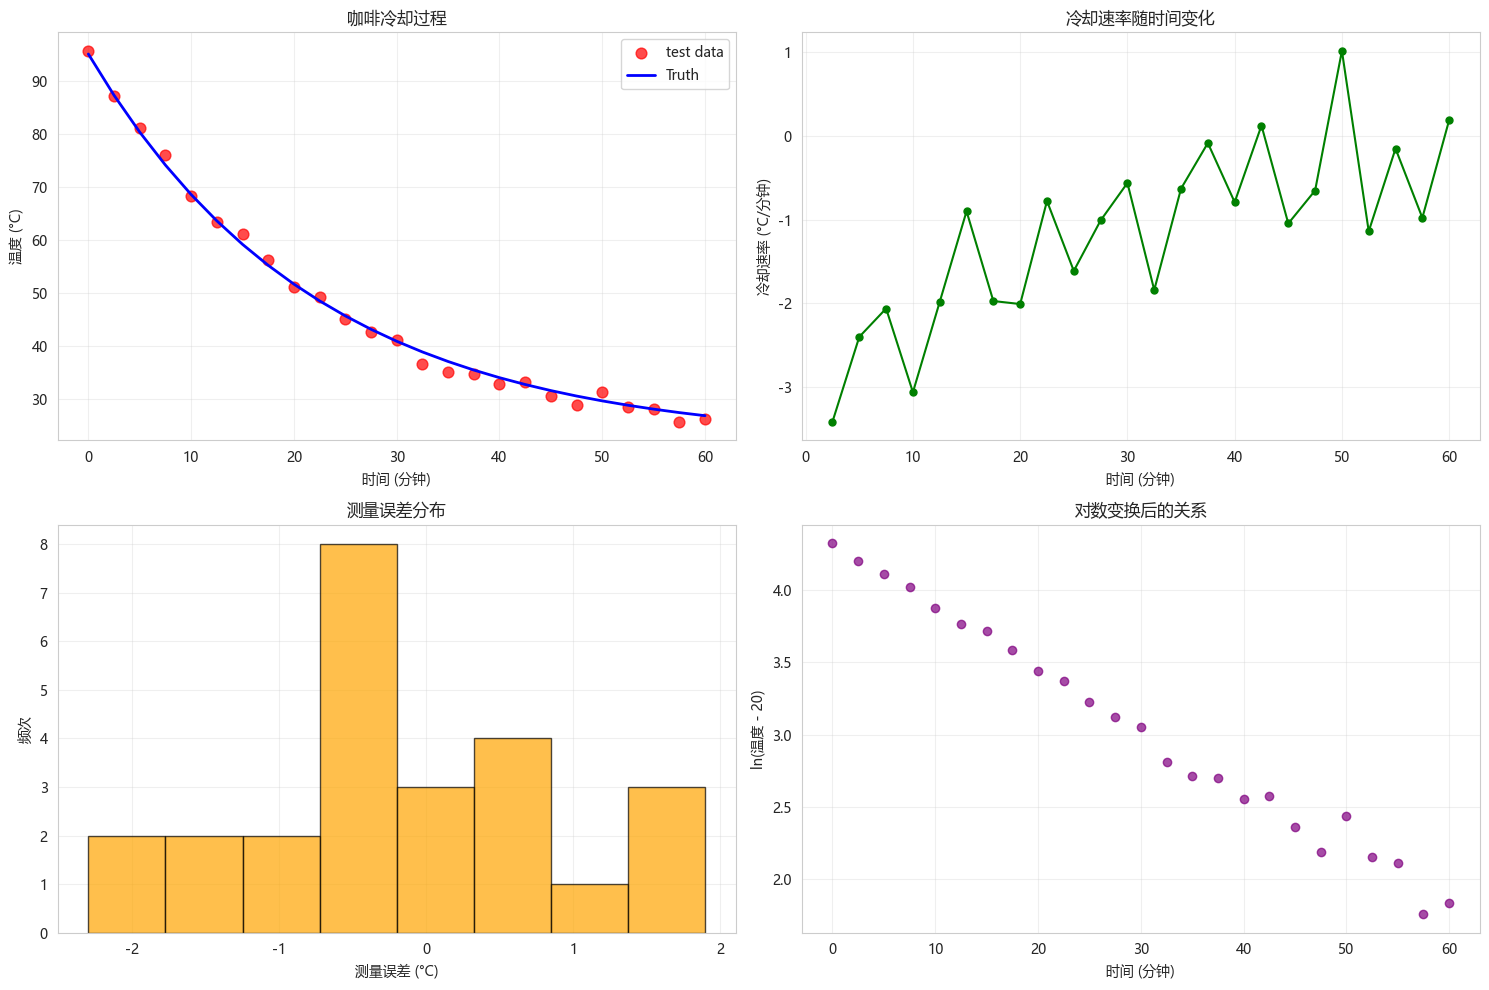

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 原始数据散点图
axes[0, 0].scatter(time_data, measured_temp, color='red', alpha=0.7, s=60, label='test data')
axes[0, 0].plot(time_data, true_temp, color='blue', linewidth=2, label='Truth')
axes[0, 0].set_xlabel('时间 (分钟)')
axes[0, 0].set_ylabel('温度 (°C)')
axes[0, 0].set_title('咖啡冷却过程')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
# 温度随时间变化率
temp_diff = np.diff(measured_temp)
time_diff = np.diff(time_data)
cooling_rate = temp_diff / time_diff

axes[0, 1].plot(time_data[1:], cooling_rate, 'o-', color='green', markersize=5)
axes[0, 1].set_xlabel('时间 (分钟)')
axes[0, 1].set_ylabel('冷却速率 (°C/分钟)')
axes[0, 1].set_title('冷却速率随时间变化')
axes[0, 1].grid(True, alpha=0.3)

# 测量误差分布
axes[1, 0].hist(df['温度差'], bins=8, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('测量误差 (°C)')
axes[1, 0].set_ylabel('频次')
axes[1, 0].set_title('测量误差分布')
axes[1, 0].grid(True, alpha=0.3)

# 温度vs时间的对数关系
axes[1, 1].scatter(time_data, np.log(measured_temp - 20), color='purple', alpha=0.7)
axes[1, 1].set_xlabel('时间 (分钟)')
axes[1, 1].set_ylabel('ln(温度 - 20)')
axes[1, 1].set_title('对数变换后的关系')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. 定义非线性回归模型

In [8]:
def newton_cooling_model(t, T_room, T_diff, k):
    """
    牛顿冷却定律模型
    T = T_room + T_diff * exp(-k * t)
    
    参数：
    t: 时间
    T_room: 室温
    T_diff: 初始温度差 (T_initial - T_room)
    k: 冷却系数
    """
    return T_room + T_diff * np.exp(-k * t)

def exponential_decay_model(t, a, b, c):
    """
    通用指数衰减模型
    T = a + b * exp(-c * t)
    """
    return a + b * np.exp(-c * t)

# 4. 参数估计 - 多种方法比较

In [18]:
print("\n🔧 模型拟合与参数估计")
print("-" * 40)

# 方法1：直接使用牛顿冷却定律
print("方法1：牛顿冷却定律拟合")

# 智能初值设定
T_room_init = min(measured_temp)  # 最低温度作为室温估计
T_diff_init = max(measured_temp) - T_room_init  # 初始温度差
k_init = 0.05  # 经验值
initial_guess_1 = [T_room_init, T_diff_init, k_init]

print(f"初始猜测值: T_room={T_room_init:.1f}, T_diff={T_diff_init:.1f}, k={k_init:.3f}")

try:
    # 参数拟合
    popt_1, pcov_1 = curve_fit(newton_cooling_model, time_data, measured_temp, 
                              p0=initial_guess_1, maxfev=10000)
    
    # 预测
    y_pred_1 = newton_cooling_model(time_data, *popt_1)
    
    # 计算评估指标
    r2_1 = r2_score(measured_temp, y_pred_1)
    rmse_1 = np.sqrt(mean_squared_error(measured_temp, y_pred_1))
    mae_1 = mean_absolute_error(measured_temp, y_pred_1)
    
    print(f"拟合参数: T_room={popt_1[0]:.2f}°C, T_diff={popt_1[1]:.2f}°C, k={popt_1[2]:.4f}")
    print(f"评估指标: R²={r2_1:.4f}, RMSE={rmse_1:.2f}°C, MAE={mae_1:.2f}°C")
    
    # 参数标准误差
    param_std_1 = np.sqrt(np.diag(pcov_1))
    print(f"参数标准误差: ±{param_std_1[0]:.2f}, ±{param_std_1[1]:.2f}, ±{param_std_1[2]:.4f}")
    
except RuntimeError as e:
    print(f"拟合失败: {e}")

# 方法2：通用指数衰减模型
print("\n方法2：通用指数衰减模型拟合")

initial_guess_2 = [T_room_init, T_diff_init, k_init]

try:
    popt_2, pcov_2 = curve_fit(exponential_decay_model, time_data, measured_temp, 
                              p0=initial_guess_2, maxfev=10000)
    
    y_pred_2 = exponential_decay_model(time_data, *popt_2)
    
    r2_2 = r2_score(measured_temp, y_pred_2)
    rmse_2 = np.sqrt(mean_squared_error(measured_temp, y_pred_2))
    mae_2 = mean_absolute_error(measured_temp, y_pred_2)
    
    print(f"拟合参数: a={popt_2[0]:.2f}, b={popt_2[1]:.2f}, c={popt_2[2]:.4f}")
    print(f"评估指标: R²={r2_2:.4f}, RMSE={rmse_2:.2f}°C, MAE={mae_2:.2f}°C")
    
except RuntimeError as e:
    print(f"拟合失败: {e}")




🔧 模型拟合与参数估计
----------------------------------------
方法1：牛顿冷却定律拟合
初始猜测值: T_room=25.8, T_diff=69.8, k=0.050
拟合参数: T_room=20.90°C, T_diff=74.92°C, k=0.0445
评估指标: R²=0.9975, RMSE=1.01°C, MAE=0.83°C
参数标准误差: ±0.91, ±0.87, ±0.0016

方法2：通用指数衰减模型拟合
拟合参数: a=20.90, b=74.92, c=0.0445
评估指标: R²=0.9975, RMSE=1.01°C, MAE=0.83°C


# 5. 模型比较与可视化


📊 模型比较
----------------------------------------
真实参数 vs 估计参数:
T_room: 真实值=22.0°C, 估计值=20.9°C
T_diff: 真实值=73.0°C, 估计值=74.9°C
k: 真实值=0.0450, 估计值=0.0445


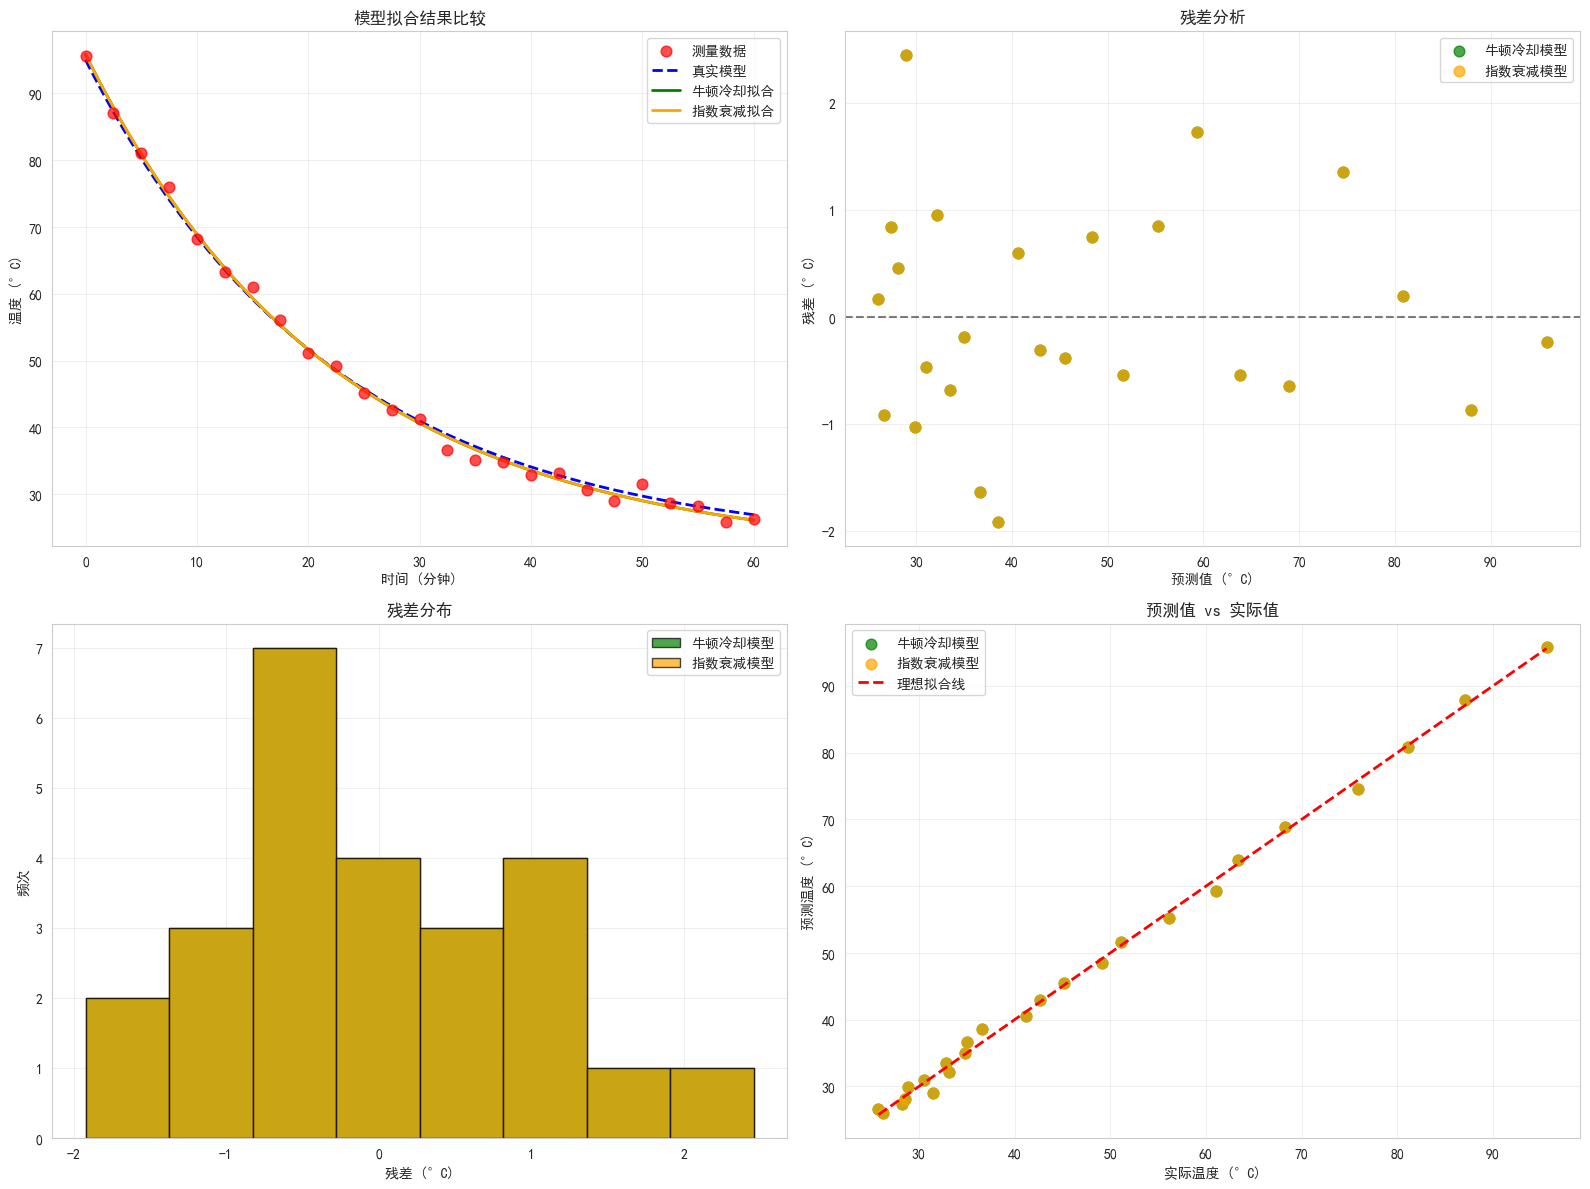

In [29]:
# 5. 模型比较与可视化
print("\n📊 模型比较")
print("-" * 40)

# 比较真实参数与估计参数
print("真实参数 vs 估计参数:")
print(f"T_room: 真实值={true_params[0]:.1f}°C, 估计值={popt_1[0]:.1f}°C")
print(f"T_diff: 真实值={true_params[1] - true_params[0]:.1f}°C, 估计值={popt_1[1]:.1f}°C")
print(f"k: 真实值={true_params[2]:.4f}, 估计值={popt_1[2]:.4f}")

# 创建详细的模型比较图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 拟合结果对比
time_plot = np.linspace(0, 60, 200)
y_true_plot = newton_cooling_model(time_plot, true_params[0], true_params[1] - true_params[0], true_params[2])
y_pred_plot_1 = newton_cooling_model(time_plot, *popt_1)
y_pred_plot_2 = exponential_decay_model(time_plot, *popt_2)

axes[0, 0].scatter(time_data, measured_temp, color='red', alpha=0.7, s=60, label='测量数据', zorder=5)
axes[0, 0].plot(time_plot, y_true_plot, color='blue', linewidth=2, label='真实模型', linestyle='--')
axes[0, 0].plot(time_plot, y_pred_plot_1, color='green', linewidth=2, label='牛顿冷却拟合')
axes[0, 0].plot(time_plot, y_pred_plot_2, color='orange', linewidth=2, label='指数衰减拟合')
axes[0, 0].set_xlabel('时间 (分钟)')
axes[0, 0].set_ylabel('温度 (°C)')
axes[0, 0].set_title('模型拟合结果比较')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 残差分析
residuals_1 = measured_temp - y_pred_1
residuals_2 = measured_temp - y_pred_2

axes[0, 1].scatter(y_pred_1, residuals_1, color='green', alpha=0.7, s=60, label='牛顿冷却模型')
axes[0, 1].scatter(y_pred_2, residuals_2, color='orange', alpha=0.7, s=60, label='指数衰减模型')
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('预测值 (°C)')
axes[0, 1].set_ylabel('残差 (°C)')
axes[0, 1].set_title('残差分析')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 误差分布
axes[1, 0].hist(residuals_1, bins=8, alpha=0.7, color='green', label='牛顿冷却模型', edgecolor='black')
axes[1, 0].hist(residuals_2, bins=8, alpha=0.7, color='orange', label='指数衰减模型', edgecolor='black')
axes[1, 0].set_xlabel('残差 (°C)')
axes[1, 0].set_ylabel('频次')
axes[1, 0].set_title('残差分布')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 预测vs实际
axes[1, 1].scatter(measured_temp, y_pred_1, color='green', alpha=0.7, s=60, label='牛顿冷却模型')
axes[1, 1].scatter(measured_temp, y_pred_2, color='orange', alpha=0.7, s=60, label='指数衰减模型')
axes[1, 1].plot([measured_temp.min(), measured_temp.max()], 
                [measured_temp.min(), measured_temp.max()], 
                'r--', linewidth=2, label='理想拟合线')
axes[1, 1].set_xlabel('实际温度 (°C)')
axes[1, 1].set_ylabel('预测温度 (°C)')
axes[1, 1].set_title('预测值 vs 实际值')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. 模型诊断

In [30]:
# 6. 模型诊断
print("\n 模型诊🔍断")
print("-" * 40)

# 残差正态性检验
from scipy import stats

# Shapiro-Wilk正态性检验
stat_1, p_value_1 = stats.shapiro(residuals_1)
stat_2, p_value_2 = stats.shapiro(residuals_2)

print("残差正态性检验 (Shapiro-Wilk):")
print(f"牛顿冷却模型: 统计量={stat_1:.4f}, p值={p_value_1:.4f}")
print(f"指数衰减模型: 统计量={stat_2:.4f}, p值={p_value_2:.4f}")
print("注: p值>0.05表示残差服从正态分布")

# 残差自相关性检验
def durbin_watson_test(residuals):
    """Durbin-Watson检验统计量"""
    n = len(residuals)
    if n < 2:
        return None
    
    diff_residuals = np.diff(residuals)
    sum_squared_diff = np.sum(diff_residuals**2)
    sum_squared_residuals = np.sum(residuals**2)
    
    dw = sum_squared_diff / sum_squared_residuals
    return dw

dw_1 = durbin_watson_test(residuals_1)
dw_2 = durbin_watson_test(residuals_2)

print(f"\n残差自相关性检验 (Durbin-Watson):")
print(f"牛顿冷却模型: DW={dw_1:.4f}")
print(f"指数衰减模型: DW={dw_2:.4f}")
print("注: DW≈2表示无自相关，0<DW<2表示正自相关，2<DW<4表示负自相关")


🔍 模型诊断
----------------------------------------
残差正态性检验 (Shapiro-Wilk):
牛顿冷却模型: 统计量=0.9766, p值=0.8100
指数衰减模型: 统计量=0.9766, p值=0.8100
注: p值>0.05表示残差服从正态分布

残差自相关性检验 (Durbin-Watson):
牛顿冷却模型: DW=2.0792
指数衰减模型: DW=2.0792
注: DW≈2表示无自相关，0<DW<2表示正自相关，2<DW<4表示负自相关


# 7. 交叉验证


✅ 交叉验证
----------------------------------------
牛顿冷却模型交叉验证结果:
R²: 0.8939 ± 0.2030
RMSE: 1.16 ± 0.36 °C

🔮 未来温度预测
----------------------------------------
未来温度预测结果:
    时间(分钟)   预测温度(°C)  95%置信区间下界  95%置信区间上界    预测区间宽度
0     60.0  26.088595  24.157723  28.134506  3.976783
1     62.5  25.542636  23.604220  27.589437  3.985217
2     65.0  25.054177  23.142311  27.076625  3.934314
3     67.5  24.617162  22.736096  26.649513  3.913417
4     70.0  24.226172  22.374286  26.263792  3.889506
5     72.5  23.876360  22.066193  25.880263  3.814070
6     75.0  23.563390  21.789259  25.563391  3.774132
7     77.5  23.283381  21.508915  25.258574  3.749659
8     80.0  23.032862  21.279812  24.980785  3.700972
9     82.5  22.808727  21.054919  24.723882  3.668963
10    85.0  22.608198  20.864361  24.512048  3.647688
11    87.5  22.428788  20.702785  24.330813  3.628028
12    90.0  22.268273  20.549345  24.161960  3.612615


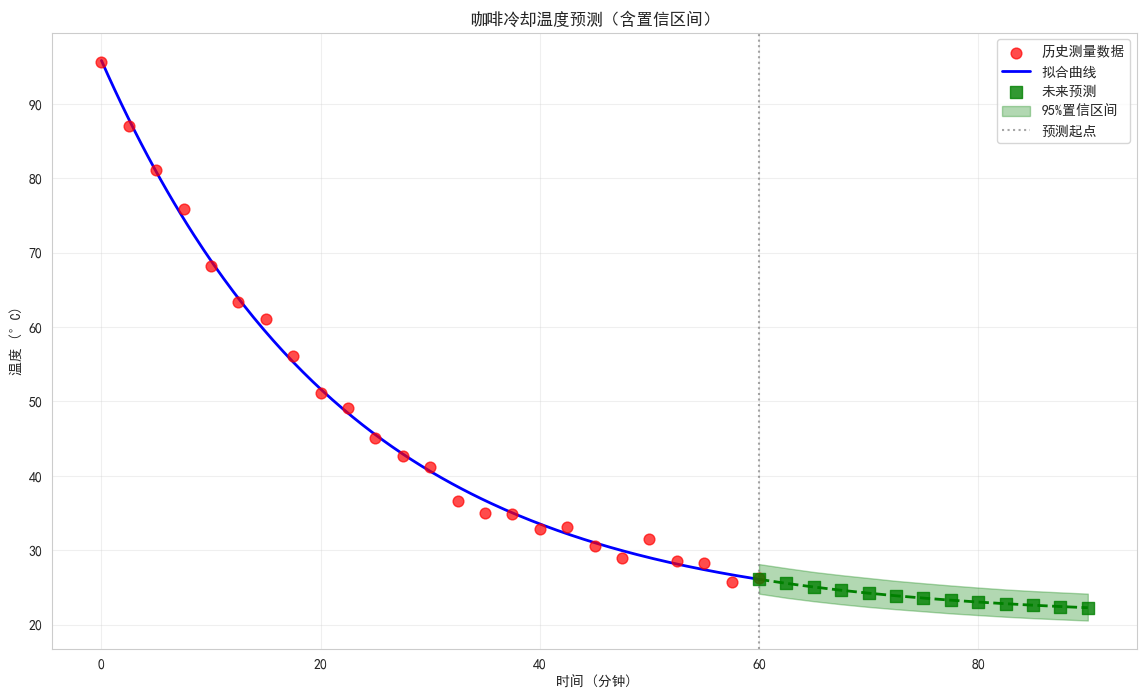


🔬 物理意义解释
----------------------------------------
估计的室温: 20.9°C
估计的初始温度: 95.8°C
估计的冷却系数: 0.0445 min⁻¹
冷却半衰期: 15.6分钟
降到25.9°C需要: 60.8分钟

📋 模型总结报告
🎯 模型性能:
   • 拟合优度 (R²): 0.9975
   • 均方根误差 (RMSE): 1.01°C
   • 平均绝对误差 (MAE): 0.83°C
   • 交叉验证 R²: 0.8939 ± 0.2030

📊 参数估计:
   • 室温: 20.9 ± 0.9°C
   • 初始温度: 95.8 ± 0.9°C
   • 冷却系数: 0.0445 ± 0.0016 min⁻¹

🔍 模型诊断:
   • 残差正态性: ✓ (p=0.8100)
   • 自相关性: ✓ (DW=2.0792)

🌟 实际应用:
   • 冷却半衰期: 15.6分钟
   • 适饮温度时间: 60.8分钟
   • 模型适用范围: 0-90分钟

💡 建议:
   • 模型拟合优秀，可用于实际预测
   • 残差服从正态分布，模型假设合理

案例1分析完成！


In [31]:
# 7. 交叉验证
print("\n✅ 交叉验证")
print("-" * 40)

from sklearn.model_selection import KFold

def cross_validate_nonlinear(X, y, model_func, initial_guess, cv=5):
    """非线性模型的交叉验证"""
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    r2_scores = []
    rmse_scores = []
    
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        try:
            # 拟合模型
            popt, _ = curve_fit(model_func, X_train, y_train, p0=initial_guess, maxfev=10000)
            
            # 预测
            y_pred = model_func(X_test, *popt)
            
            # 计算指标
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
            r2_scores.append(r2)
            rmse_scores.append(rmse)
            
        except RuntimeError:
            continue
    
    return np.array(r2_scores), np.array(rmse_scores)

# 对牛顿冷却模型进行交叉验证
r2_cv_1, rmse_cv_1 = cross_validate_nonlinear(time_data, measured_temp, 
                                              newton_cooling_model, initial_guess_1)

print(f"牛顿冷却模型交叉验证结果:")
print(f"R²: {r2_cv_1.mean():.4f} ± {r2_cv_1.std():.4f}")
print(f"RMSE: {rmse_cv_1.mean():.2f} ± {rmse_cv_1.std():.2f} °C")

# 8. 预测未来温度
print("\n🔮 未来温度预测")
print("-" * 40)

# 预测未来30分钟的温度
future_time = np.linspace(60, 90, 13)  # 60-90分钟，每2.5分钟一个点
future_temp_pred = newton_cooling_model(future_time, *popt_1)

# 计算预测区间（基于参数不确定性）
param_std = np.sqrt(np.diag(pcov_1))
n_simulations = 1000

# 蒙特卡洛模拟预测区间
future_predictions = []
for _ in range(n_simulations):
    # 从参数的正态分布中采样
    sampled_params = np.random.normal(popt_1, param_std)
    pred = newton_cooling_model(future_time, *sampled_params)
    future_predictions.append(pred)

future_predictions = np.array(future_predictions)
pred_lower = np.percentile(future_predictions, 2.5, axis=0)  # 95%置信区间下界
pred_upper = np.percentile(future_predictions, 97.5, axis=0)  # 95%置信区间上界

# 创建预测结果表
pred_df = pd.DataFrame({
    '时间(分钟)': future_time,
    '预测温度(°C)': future_temp_pred,
    '95%置信区间下界': pred_lower,
    '95%置信区间上界': pred_upper,
    '预测区间宽度': pred_upper - pred_lower
})

print("未来温度预测结果:")
print(pred_df)

# 可视化预测结果
plt.figure(figsize=(14, 8))

# 历史数据
plt.scatter(time_data, measured_temp, color='red', alpha=0.7, s=60, label='历史测量数据', zorder=5)
plt.plot(time_plot, y_pred_plot_1, color='blue', linewidth=2, label='拟合曲线')

# 预测数据
plt.scatter(future_time, future_temp_pred, color='green', alpha=0.8, s=80, 
           marker='s', label='未来预测', zorder=5)
plt.fill_between(future_time, pred_lower, pred_upper, alpha=0.3, color='green', 
                label='95%置信区间')

# 连接线
plt.plot(future_time, future_temp_pred, color='green', linewidth=2, linestyle='--')

plt.axvline(x=60, color='gray', linestyle=':', alpha=0.7, label='预测起点')
plt.xlabel('时间 (分钟)')
plt.ylabel('温度 (°C)')
plt.title('咖啡冷却温度预测（含置信区间）')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 9. 物理意义解释
print("\n🔬 物理意义解释")
print("-" * 40)

estimated_T_room = popt_1[0]
estimated_T_initial = popt_1[0] + popt_1[1]
estimated_k = popt_1[2]

print(f"估计的室温: {estimated_T_room:.1f}°C")
print(f"估计的初始温度: {estimated_T_initial:.1f}°C")
print(f"估计的冷却系数: {estimated_k:.4f} min⁻¹")

# 计算半衰期（温度差减半所需时间）
half_life = np.log(2) / estimated_k
print(f"冷却半衰期: {half_life:.1f}分钟")

# 计算到达特定温度的时间
def time_to_reach_temp(target_temp, T_room, T_initial, k):
    """计算到达目标温度所需的时间"""
    if target_temp <= T_room or target_temp >= T_initial:
        return None
    return -np.log((target_temp - T_room) / (T_initial - T_room)) / k

# 计算降到室温+5°C所需的时间
time_to_warm = time_to_reach_temp(estimated_T_room + 5, estimated_T_room, estimated_T_initial, estimated_k)
print(f"降到{estimated_T_room + 5:.1f}°C需要: {time_to_warm:.1f}分钟")

# 10. 总结报告
print("\n📋 模型总结报告")
print("=" * 60)

print("🎯 模型性能:")
print(f"   • 拟合优度 (R²): {r2_1:.4f}")
print(f"   • 均方根误差 (RMSE): {rmse_1:.2f}°C")
print(f"   • 平均绝对误差 (MAE): {mae_1:.2f}°C")
print(f"   • 交叉验证 R²: {r2_cv_1.mean():.4f} ± {r2_cv_1.std():.4f}")

print("\n📊 参数估计:")
print(f"   • 室温: {estimated_T_room:.1f} ± {param_std_1[0]:.1f}°C")
print(f"   • 初始温度: {estimated_T_initial:.1f} ± {param_std_1[1]:.1f}°C")
print(f"   • 冷却系数: {estimated_k:.4f} ± {param_std_1[2]:.4f} min⁻¹")

print("\n🔍 模型诊断:")
print(f"   • 残差正态性: {'✓' if p_value_1 > 0.05 else '✗'} (p={p_value_1:.4f})")
print(f"   • 自相关性: {'✓' if abs(dw_1 - 2) < 0.5 else '✗'} (DW={dw_1:.4f})")

print("\n🌟 实际应用:")
print(f"   • 冷却半衰期: {half_life:.1f}分钟")
print(f"   • 适饮温度时间: {time_to_warm:.1f}分钟")
print(f"   • 模型适用范围: 0-90分钟")

print("\n💡 建议:")
if r2_1 > 0.95:
    print("   • 模型拟合优秀，可用于实际预测")
else:
    print("   • 模型拟合良好，但需要更多数据验证")

if p_value_1 > 0.05:
    print("   • 残差服从正态分布，模型假设合理")
else:
    print("   • 残差不服从正态分布，考虑模型改进")

print("\n" + "=" * 60)
print("案例1分析完成！")
print("=" * 60)